In [1]:
import nltk, re
nltk.download('stopwords')
stopwords = set(map(lambda x: re.sub("'.*", "", x), 
    nltk.corpus.stopwords.words('english')))

[nltk_data] Downloading package stopwords to /Users/gary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import os, re, math

def words_from_file(fname):
    f = open('txt/' + fname)
    text = f.read()
    f.close()
    text = re.sub('[^a-z ]', ' ', text.replace('\n', ' ').lower())
    words = re.sub(' +', ' ', text).split(' ')
    words = list(filter(lambda w: len(w) > 3 and len(w) <= 20, words))
    words = list(filter(lambda w: w not in stopwords, words))
    return list(words)

file_names = os.listdir('txt')
num_docs = len(file_names)

In [3]:
num_docs

1424

In [4]:
min_doc_frac = 0.05   # Minimum fraction doc frequency allowed
max_doc_frac = 0.75   # Maximum fraction foc frequency allowed
word_doc_freq = {}    # Dict of words to doc frequencies

# First pass: get raw doc frequencies
for fname in file_names:    
    words = set(words_from_file(fname))
    for word in words:
        word_doc_freq[word] = word_doc_freq.get(word, 0) + 1

# Discard any term that occurs too much or too little
min_doc_count = min_doc_frac * num_docs
max_doc_count = max_doc_frac * num_docs
words = list(word_doc_freq.keys())
for word in words:
    df = word_doc_freq[word]
    if df < min_doc_count or df > max_doc_count:
        del word_doc_freq[word]

In [5]:
len(word_doc_freq)

4877

In [6]:
doc_word_freq = []  # Array of docs to dicts of words to freqs
doc_num_words = []  # Array of docs to num words

# Second pass: get raw term freqs and num words
for fname in file_names:    
    words = words_from_file(fname)
    word_freq = {}
    for word in words:
        if word in word_doc_freq:
            word_freq[word] = word_freq.get(word, 0) + 1
    doc_num_words.append(len(words))
    doc_word_freq.append(word_freq)

In [7]:
doc_tfidf = []  # Array of docs to dicts of words to tfidfs
for i in range(num_docs):
    num_words = doc_num_words[i]
    word_freq = doc_word_freq[i]
    tfidf = {}
    for word in word_freq:
        tf = word_freq[word] / num_words
        idf = math.log(num_docs / word_doc_freq[word])
        tfidf[word] = tf * idf
    sumsq = 0.0
    for val in tfidf.values():
        sumsq += val * val
    norm = math.sqrt(sumsq)
    for word in tfidf:
        tfidf[word] /= norm
    doc_tfidf.append(tfidf)

In [8]:
doc_tfidf[0]

{'sciences': 0.0030430021517557264,
 'article': 0.012815844681311422,
 'patients': 0.1481473460640632,
 'assisted': 0.0930476989991339,
 'therapy': 0.11352098804085707,
 'means': 0.04097108221341768,
 'fractal': 0.08215590096344487,
 'superior': 0.0287632274234997,
 'gmail': 0.007439990111099026,
 'correspondence': 0.0056269536354763465,
 'received': 0.002166532240546191,
 'accepted': 0.0030552555583630795,
 'june': 0.01584880254366135,
 'published': 0.005691462272370364,
 'recent': 0.0023342571094411343,
 'sensor': 0.03282041676280304,
 'therapies': 0.03693812363014884,
 'children': 0.1320290528493078,
 'disabilities': 0.045161589424994444,
 'promote': 0.008797562805673556,
 'positive': 0.016852148123688106,
 'behavior': 0.10954807746320615,
 'among': 0.014991785323070614,
 'produced': 0.004122979376551428,
 'developing': 0.0044247787989889435,
 'variety': 0.009229747831653866,
 'skills': 0.017893767504524434,
 'abilities': 0.014677135806698178,
 'become': 0.0037535067903125587,
 'top

In [10]:
import numpy as np

pairs = []
min_similarity = 0.2
sims = np.zeros(shape = (num_docs, num_docs))
for i in range(num_docs):
    tfidf_i = doc_tfidf[i]
    keys_i = set(tfidf_i.keys())
    for j in range(num_docs):
        if i == j:
            sim = 1.0
        elif i < j:
            tfidf_j = doc_tfidf[j]
            keys_j = set(tfidf_j)
            keys = keys_i & keys_j
            sim = 0.0
            for key in keys:
                sim += tfidf_i[key] * tfidf_j[key]
            if sim >= min_similarity:
                pairs.append((sim, i, j))        
        else:
            sim = sims[j][i]
        sims[i][j] = sim
pairs.sort(reverse = True)

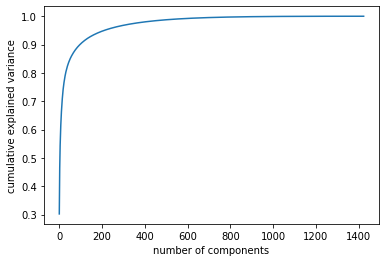

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(sims)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [175]:
np.cumsum(pca.explained_variance_ratio_[0:20])

array([0.30229197, 0.39431343, 0.46457857, 0.51540762, 0.54440158,
       0.57084341, 0.59620319, 0.61556804, 0.63374081, 0.64916971,
       0.66323945, 0.67596858, 0.68765115, 0.69845892, 0.70859777,
       0.71767249, 0.72666186, 0.73456936, 0.74221028, 0.74892177])

In [12]:
from sklearn.cluster import KMeans

In [13]:
def summarize(cluster):
    idxs = [i for i, x in enumerate(kmeans.labels_) if x == cluster]
    merge = {}
    for i in idxs:
        for word in doc_tfidf[i]:
            merge[word] = merge.get(word, 0.0) + doc_tfidf[i][word]
    summary = map(lambda x: x[0], sorted(merge.items(), 
                  key = lambda x: x[1], reverse = True)[0:10])
    print("cluster number =", cluster)
    print("size =", len(idxs), ",  features =", list(summary))
    return
    for i in idxs:
        summary = map(lambda x: x[0], sorted(doc_tfidf[i].items(), 
                      key = lambda x: x[1], reverse = True)[0:10])
        print(i, list(summary))

In [18]:
kmeans = KMeans(n_clusters=7).fit(sims)
for i in range(kmeans.n_clusters): 
    summarize(i)

cluster number = 0
size = 55 ,  features = ['game', 'games', 'player', 'players', 'playing', 'video', 'play', 'gaming', 'serious', 'user']
cluster number = 1
size = 108 ,  features = ['emotion', 'valence', 'emotions', 'arousal', 'emotional', 'affective', 'music', 'crossref', 'recognition', 'facial']
cluster number = 2
size = 212 ,  features = ['classification', 'dataset', 'feature', 'wavelet', 'classifier', 'class', 'accuracy', 'layer', 'deep', 'matrix']
cluster number = 3
size = 61 ,  features = ['para', 'como', 'este', 'forma', 'tica', 'universidad', 'cerebral', 'issn', 'solo', 'tempo']
cluster number = 4
size = 437 ,  features = ['wheelchair', 'driving', 'preprint', 'issn', 'workload', 'participants', 'students', 'meditation', 'fatigue', 'load']
cluster number = 5
size = 173 ,  features = ['ssvep', 'robot', 'wheelchair', 'robotic', 'motor', 'commands', 'bcis', 'command', 'imagery', 'user']
cluster number = 6
size = 378 ,  features = ['participants', 'music', 'musical', 'user', 'stre